# House Prices Solution [top 1%]

# 요약
#### Stats
- stats.shapiro : 샤피로 윌크 검정, 일반적으로 정규성을 검정하기 위해 사용하는 테스트.
    - 해당 검정에서의 귀무가설은 정규분포를 따른다는 것임. 즉, p-value > 0.05일 때 귀무가설을 채택, 해당 분포는 정규분포를 따른다는 점을 알 수 있음.
    - N(관측치) > 5000 이상일 때 W test statistic은 정확하지만 p-value의 정확도는 보장할 수 없음. 
    - return : test statistic(검정통계량), p-value
- stats.johnsonsu : johnson Su를 shape parameter로 사용해서 만든 Johnson SU continuous random variable
- stats.norm : normal continuous random variable
- stats.lognorm : lognormal continuous random variable

    
#### Algorithm
- TSNE (t-Stochastic Neighbor Embedding) : 고차원의 벡터로 표현되는 데이터 간의 neighbor structure를 보존하는 2차원의 embedding verctor를 학습함으로써, 고차원의 데이터를 2차원의 지도로 표현.
    - 주로 vertoc visualization을 위해 사용되는 알고리즘
    - 데이터 간의 거리를 stochastic probability로 변환하여 임베딩에 사용하기 때문.
    - stochastic probability는 perplexity에 의해 조절됨.
    - *perplexity : 학습에 영향을 주는 점들의 개수 조절
    - 원 공간에서의 데이터 유사도는 기준점x에 대한 모든 점들의 유클라디언 거리를 구하고 분산을 나눈 뒤 negative exponential를 취함. 이를 전체 확률의 합으로 나눠주면 Xi와 Xj의 유사도 파악 가능
        - 하지만 Xi를 기준점으로 계산했을 때와 Xj를 기준점으로 계산했을 때의 값이 다르기 때문에(각 점의 분산이 다르기 때문) 둘의 합의 평균으로 유사도 정의
    - [참고 사이트](https://lovit.github.io/nlp/representation/2018/09/28/tsne/)
    
    
#### Modeling
- 다양한 싱글 모델들과 stacking, boost등을 활용한 모델들을 합쳐서 blend model을 만들고 이를 캐글 상위권에 포진해있는 submission과 합침.
    - 캐글에서는 상위권 성적을 노릴 수 있지만 현업에서는 사용하기 어려운 방법이라고 생각함

### Competition Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Executive Summary
I started this competition by just focusing on getting a good understanding of the dataset. The EDA is detailed and many visualizations are inclueded. This version also includes modeling:
- Lasso regerssion model (great perform)
- XGBoost model
- LGBM model
- Dragon model

### Load packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O

# Input data files are available in the './data/' directory (in my notebook)

from datetime import datetime
from scipy.stats import skew # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
print(os.listdir('./data'))

import warnings
warnings.filterwarnings('ignore')

# Any result you write to the current directory are saved as output

['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print('Data is loaded!')

Data is loaded!


In [3]:
print('Train : {} sales, and {} features'.format(train.shape[0], train.shape[1]))
print('Test : {} sales, and {} features'.format(test.shape[0], test.shape[1]))

Train : 1460 sales, and 81 features
Test : 1459 sales, and 80 features


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## EDA

There are 1460 instances of training dataand 1460 of test data. Total number of attributes equals 81, of which 36 is quantitative, 43 categorical + ID and SalePrice.

<b>Quantitative</b>: 1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

<b>Qualitative</b>: Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities,

In [6]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [7]:
quantitative

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [8]:
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

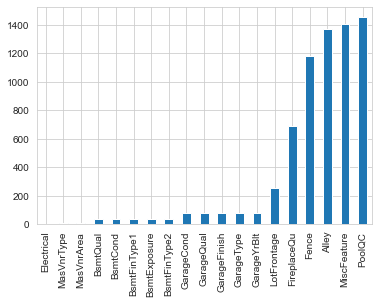

In [9]:
sns.set_style('whitegrid')
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar()
plt.show()

19 attributes have missing values, 5 over 50% of all data. Most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement.

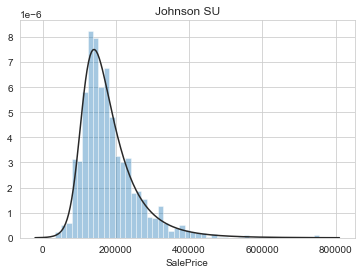

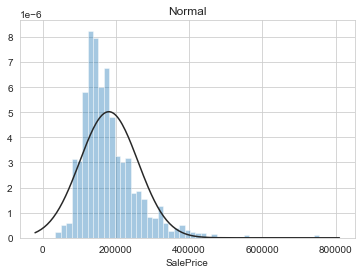

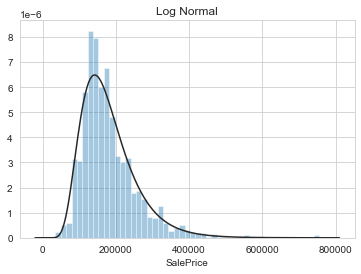

In [10]:
y = train['SalePrice']
plt.figure(0)
plt.title('Johnson SU')
sns.distplot(y, kde = False, fit= stats.johnsonsu)

plt.figure(1)
plt.title('Normal')
sns.distplot(y, kde = False, fit = stats.norm)

plt.figure(2)
plt.title('Log Normal')
sns.distplot(y, kde = False, fit = stats.lognorm)

plt.show()

It is apparent that SalePrice doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

In [11]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01 # 해당 notebook에서는 0.01을 기준으로 잡아 귀무가설을 기각하는 column을 찾음
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


Also none of quantitative variables has normal distribution so these should be transformed as well.
- Shapiro Wilk test를 통해 모든 컬럼이 정규분포 형태가 아님을 확인.

<b>Spearman correlation</b> is better to work with in this case because it picks up relationships between vaiables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.

In [12]:
# Categorical feature 인코딩
def encode(frame, feature):
    ordering = pd.DataFrame()
    # 카테고리 feature를 인덱스로 만들기 위해 val column 만들기
    # 굳이 컬럼을 만들 필요는 없어보인다.
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    # feature의 saleprice 평균에 따라 값을 정렬시키기 위한 Spmean column 만들기
    ordering['Spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('Spmean')
    # index와 ordering번호를 딕셔너리화하기 위한 ordering column 만들기 (key : index, value : ordering)
    ordering['ordering'] = range(1, ordering.shape[0] + 1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items(): # key -> cat / value -> o
        frame.loc[frame[feature] == cat, feature + '_E'] = o

qual_encoded = []
for q in qualitative:
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


어차피 해당 값들은 다시 인코딩해야할 것으로 보임

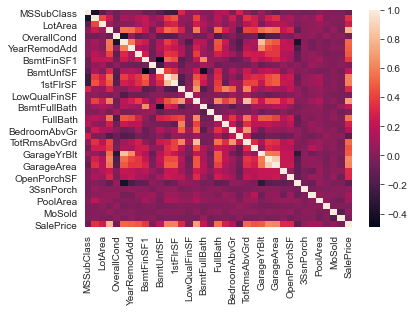

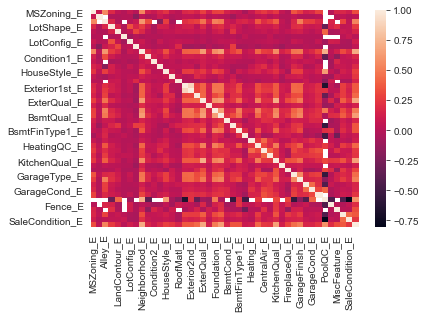

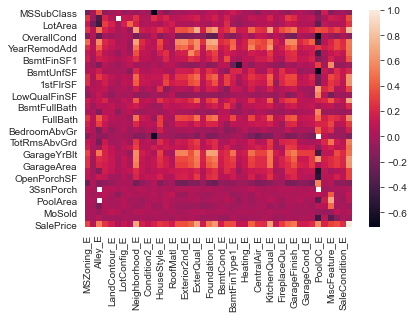

In [13]:
plt.figure(1)
corr = train[quantitative + ['SalePrice']].corr()
sns.heatmap(corr)

plt.figure(2)
corr = train[qual_encoded + ['SalePrice']].corr()
sns.heatmap(corr)

plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative) + 1, len(qual_encoded) + 1]), 
                    index = quantitative + ['SalePrice'], columns = qual_encoded + ['SalePrice'])
for q1 in quantitative + ['SalePrice']:
    for q2 in qual_encoded + ['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)
plt.show()

### Simple clustering

0.7545192516184854


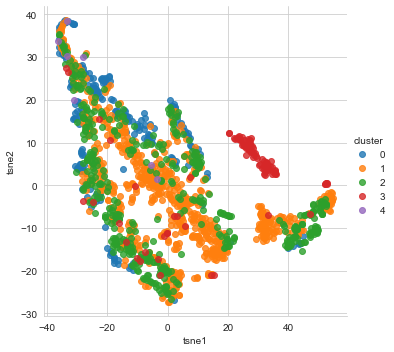

In [14]:
features = quantitative + qual_encoded
# TSNE에는 정규화를 거치지 않은 X
model = TSNE(n_components = 2, random_state = 0, perplexity = 50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

# PCA에는 정규화된 X
std = StandardScaler()
s = std.fit_transform(X)

pca = PCA(n_components = 30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters = 5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1' : tsne[:,0], 'tsne2' : tsne[:, 1], 'cluster' : kmeans.labels_})
sns.lmplot(data = fr, x = 'tsne1', y = 'tsne2', hue = 'cluster', fit_reg = False)
print(np.sum(pca.explained_variance_ratio_))

# Models

Data processing

In [15]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [16]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop = True, inplace = True)
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice'].reset_index(drop = True)

### Features

In [17]:
train_features = train.drop(['SalePrice'], axis = 1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [18]:
features.shape

(2917, 122)

In [19]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,2.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0


In [20]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')
    
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [21]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,2.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0


In [22]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
# dataframe.update : 삽입, 수정 용도로 사용 가능 (overwrite = True)가 default
features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []

for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
        
features.update(features[numerics].fillna(0))

In [23]:
skew_features = features[numerics].apply(lambda x: skew(x)).sort_values(ascending = False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [24]:
features = features.drop(['Utilities', 'Street', 'PoolQC'], axis = 1)

features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                features['1stFlrSF'] + features['2ndFlrSF'])
features['Total_Bathrooms'] = (features['FullBath'] + (features['HalfBath'] * 0.5) +
                              features['BsmtFullBath'] + (features['BsmtHalfBath'] * 0.5))
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] + 
                             features['EnclosedPorch'] + features['ScreenPorch'] +
                             features['WoodDeckSF'])

In [25]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [26]:
features.shape

(2917, 129)

In [27]:
final_features = pd.get_dummies(features).reset_index(drop = True)
final_features.shape

(2917, 352)

In [28]:
X = final_features.iloc[:len(y)]
X_sub = final_features.iloc[len(y):]
X.shape, y.shape, X_sub.shape

((1458, 352), (1458,), (1459, 352))

In [29]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)
        
        
overfit = list(overfit)
X = X.drop(overfit, axis = 1)
X_sub = X_sub.drop(overfit, axis = 1)

In [30]:
X.shape, y.shape, X_sub.shape

((1453, 347), (1453,), (1459, 347))

In [44]:
kfolds= KFold(n_splits = 10, shuffle = True, random_state = 42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = kfolds))
    return rmse

In [35]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.3, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [37]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = alphas_alt, cv = kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter = 1e7, alphas = alphas2, random_state = 42, cv = kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter = 1e7, alphas = e_alphas,
                                                     cv = kfolds, l1_ratio = e_l1ratio))
svr = make_pipeline(RobustScaler(), SVR(C = 20, epsilon = 0.008, gamma = 0.0003))

In [39]:
gbr = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05, max_depth = 4,
                               max_features = 'sqrt', min_samples_leaf = 15, min_samples_split = 10,
                               loss = 'huber', random_state = 42)

In [40]:
lightgbm = LGBMRegressor(objective = 'regression',
                        num_leaves = 4,
                        learning_rate = 0.01,
                        n_estimators = 5000,
                        max_bin = 200,
                        bagging_fraction = 0.75,
                        bagging_freq = 5,
                        bagging_seed = 7,
                        feature_fraction = 0.2,
                        feature_fraction_seed = 7,
                        verbose = -1)

In [41]:
xgboost = XGBRegressor(learning_rate = 0.01, n_estimators = 3460,
                      max_depth = 3, min_child_weight = 0,
                      gamma = 0, subsample = 0.7,
                      colsample_bytree = 0.7,
                      objective = 'reg:linear', nthread = -1,
                      scale_pos_weight = 1, seed = 27,
                      reg_alpha = 0.00006)

In [42]:
stack_gen = StackingCVRegressor(regressors = (ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                               meta_regressor = xgboost, use_features_in_secondary = True)

In [46]:
score = cv_rmse(ridge)
print('Ridge : {:.4f} ({:.4f})'.format(score.mean(), score.std()), datetime.now())

score = cv_rmse(lasso)
print('LASSO : {:.4f} ({:.4f})'.format(score.mean(), score.std()), datetime.now())

score = cv_rmse(svr)
print('SVR : {:.4f} ({:.4f})'.format(score.mean(), score.std()), datetime.now())

score = cv_rmse(lightgbm)
print("lightgbm : {:.4f} ({:.4f})".format(score.mean(), score.std()), datetime.now())

score = cv_rmse(gbr)
print('GBR : {:.4f} ({:.4f})'.format(score.mean(), score.std()), datetime.now())

score = cv_rmse(xgboost)
print('xgboost : {:.4f} ({:.4f})'.format(score.mean(), score.std()), datetime.now())

Ridge : 0.1006 (0.0137) 2020-12-17 11:16:02.727731
LASSO : 0.1004 (0.0146) 2020-12-17 11:16:17.786559
SVR : 0.1015 (0.0115) 2020-12-17 11:16:26.875572
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] ba

In [47]:
print('START Fit')

print('Stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xbgoost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
Stack_gen
[11:21:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/

## Blending Models 

In [50]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) +
           (0.05 * lasso_model_full_data.predict(X)) +
           (0.1 * ridge_model_full_data.predict(X)) +
           (0.1 * svr_model_full_data.predict(X)) +
           (0.1 * gbr_model_full_data.predict(X)) +
           (0.15 * lgb_model_full_data.predict(X)) +
           (0.1 * lgb_model_full_data.predict(X)) +
           (0.3 * stack_gen_model.predict(np.array(X))))

In [51]:
print('RMSLE score on train data :')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data :
0.056175403632843394


In [53]:
print('Predict submission')
submission = pd.read_csv('./data/sample_submission.csv')
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

Predict submission


# Submission

In [58]:
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x * 0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv('submission.csv', index = False)

In [59]:
submission.head()

,Id,SalePrice
0,1461,62082.0
1,1462,74832.0
2,1463,90715.0
3,1464,96281.0
4,1465,86702.0
